# Análisis de medidas de vacío

Este cuaderno analiza datos experimentales de un sistema de vacío, con el objetivo de calcular la velocidad de bombeo y evaluar la eficiencia del sistema. 

## Contexto
Los datos provienen de un experimento donde se midió la presión vs tiempo durante la evacuación de una cámara de vacío con un volumen estimado de **4.39 ± 0.01 L**, utilizando una bomba mecánica Dual Stage Rotary Vane 2005 C1.

## Análisis realizado
Este notebook:

1. Carga los datos de `datos-vacio.csv` (mediciones de presión en función del tiempo)
2. Realiza limpieza de datos (convertir comas decimales)
3. Genera visualizaciones lineal y semilogarítmica de P vs t
4. Ajusta los datos a un modelo exponencial: P(t) = P_inf + (P0 - P_inf) * exp(-k * t)
5. Estima la constante de decaimiento `k` (y su incertidumbre) y el tiempo característico `tau = 1/k` 
6. Calcula la velocidad de bombeo `S` utilizando la relación S = -V * (dP/dt)/(P-P_inf)
7. Compara el ajuste exponencial con la aproximación lineal para presiones altas

Los resultados se guardan en la carpeta `results/` dentro del directorio del notebook.

In [29]:
# Recomendación: si alguna import falla, ejecuta `pip install pandas numpy matplotlib seaborn scipy uncertainties` en tu entorno.
try:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy.optimize import curve_fit
    from pathlib import Path
    import warnings
    warnings.filterwarnings('ignore')
except Exception as e:
    print('Error importing libraries:', e)
    raise

In [30]:
# Rutas
DATA_PATH = Path('/home/juan/Workspace/Base/Python/Lab2/datos-vacio.csv')
RESULTS_DIR = Path('/home/juan/Workspace/Base/Python/Lab2/results')
RESULTS_DIR.mkdir(exist_ok=True)
DATA_PATH.exists()

True

In [31]:
# Cargar datos: el archivo usa comas decimales y quotechar '"'.
df = pd.read_csv(DATA_PATH, header=None, names=['t','P'], decimal=',', quotechar='"')
# Convertir a numérico por si acaso
df['t'] = pd.to_numeric(df['t'], errors='coerce')
df['P'] = pd.to_numeric(df['P'], errors='coerce')
df = df.dropna().reset_index(drop=True)
df.head()

,t,P
0,0.00,750.0
1,1.00,730.0
2,3.00,710.0
3,3.17,690.0
4,3.33,670.0


In [32]:
# Inspección rápida
print('Filas:', len(df))
display(df.describe())
# Visualizar algunos puntos atípicos (si los hay)
df[df['P']<=0].head()

Filas: 285


,t,P
count,285.000000,285.000000
mean,31.829895,77.415825
std,33.121371,170.852299
min,0.000000,0.040000
25%,7.420000,0.070000
50%,13.250000,0.450000
75%,51.000000,17.000000
max,125.000000,750.000000


,t,P


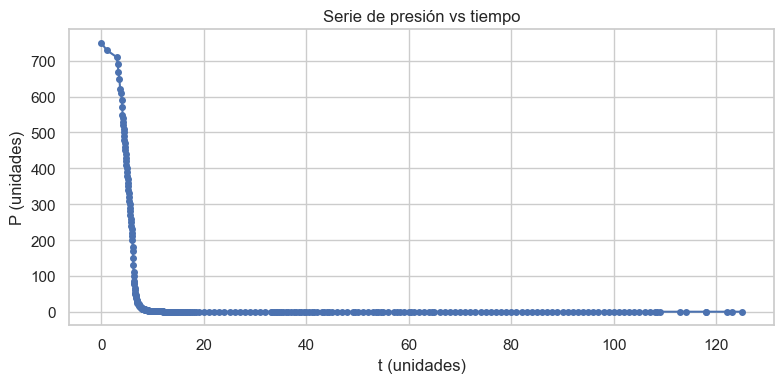

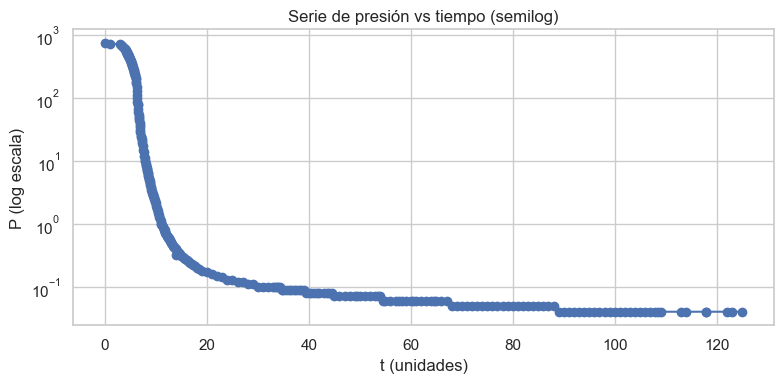

In [33]:
# Gráficas: dispersión y semilog
sns.set(style='whitegrid')
plt.figure(figsize=(8,4))
plt.plot(df['t'], df['P'], 'o-', markersize=4)
plt.xlabel('t (unidades)')
plt.ylabel('P (unidades)')
plt.title('Serie de presión vs tiempo')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'P_vs_t_linear.png', dpi=150)
plt.show()

plt.figure(figsize=(8,4))
plt.semilogy(df['t'], df['P'], 'o-')
plt.xlabel('t (unidades)')
plt.ylabel('P (log escala)')
plt.title('Serie de presión vs tiempo (semilog)')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'P_vs_t_semilog.png', dpi=150)
plt.show()

## Ajuste a un decaimiento exponencial
Supondremos el modelo:

P(t) = P_inf + (P0 - P_inf) * exp(-k * t)

con parámetros P_inf (presión final), P0 (presión inicial) y k (constante).

P_inf = -23.68 ± 6.3
P0    = 1244.2 ± 58
k     = 0.27887 ± 0.011
tau = 1/k = 3.5858 (unidades de tiempo)


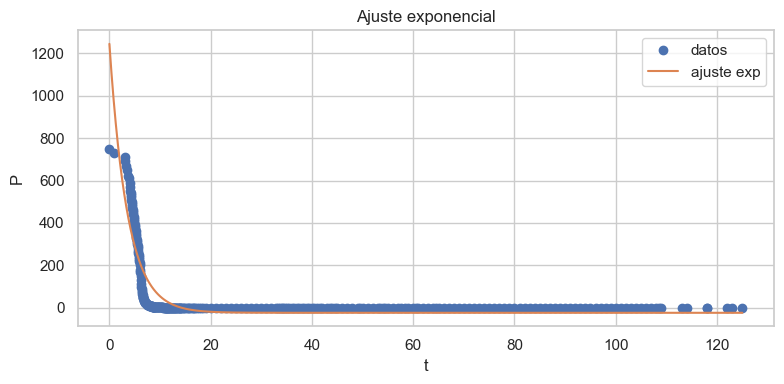

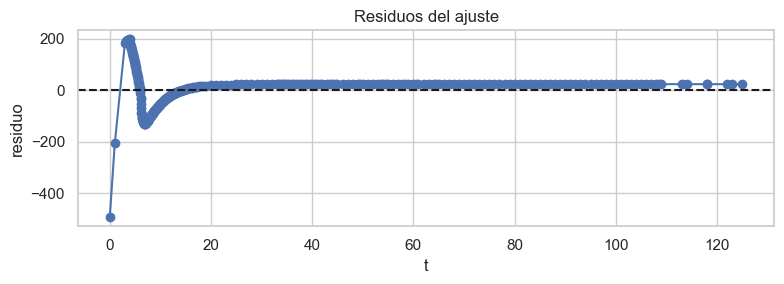

In [34]:
def model_exp(t, P_inf, P0, k):
    return P_inf + (P0 - P_inf) * np.exp(-k * t)

t = df['t'].values
P = df['P'].values
# Guess inicial
p0 = [P.min(), P[0], 0.1]
try:
    popt, pcov = curve_fit(model_exp, t, P, p0=p0, maxfev=10000)
    perr = np.sqrt(np.diag(pcov))
    P_inf, P0_fit, k = popt
    dP_inf, dP0, dk = perr
    print(f'P_inf = {P_inf:.5g} ± {dP_inf:.2g}')
    print(f'P0    = {P0_fit:.5g} ± {dP0:.2g}')
    print(f'k     = {k:.5g} ± {dk:.2g}')
    print(f'tau = 1/k = {1.0/k:.5g} (unidades de tiempo)')
except Exception as e:
    print('Ajuste falló:', e)
    popt = None

# Graficar ajuste si salió
if popt is not None:
    t_fit = np.linspace(t.min(), t.max(), 300)
    P_fit = model_exp(t_fit, *popt)
    plt.figure(figsize=(8,4))
    plt.plot(t, P, 'o', label='datos')
    plt.plot(t_fit, P_fit, '-', label='ajuste exp')
    plt.xlabel('t')
    plt.ylabel('P')
    plt.legend()
    plt.title('Ajuste exponencial')
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'ajuste_exponencial.png', dpi=150)
    plt.show()

    # Residuos
    P_model_at_data = model_exp(t, *popt)
    resid = P - P_model_at_data
    plt.figure(figsize=(8,3))
    plt.plot(t, resid, 'o-')
    plt.axhline(0, color='k', ls='--')
    plt.xlabel('t')
    plt.ylabel('residuo')
    plt.title('Residuos del ajuste')
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'residuos_ajuste.png', dpi=150)
    plt.show()

## Cálculo de la velocidad de bombeo S

Si el modelo válido es dP/dt = - (S/V) * (P - P_inf), entonces la solución tiene forma exponencial y `k = S / V`. Por tanto S = k * V.

A continuación se define una función para calcular S dado V (en m^3).

In [ ]:
def calcular_S(V_m3, k, dk=None):
    S = k * V_m3
    if dk is None:
        return S
    else:
        # propagación de incertidumbre (S = k * V, asumimos V conocida sin error)
        dS = dk * V_m3
        return S, dS

    # Usar el volumen estimado en el artículo: 4.39 L = 0.00439 m^3
V_example = 4.39 / 1000.0  # m^3

if popt is not None:
    try:
        S_val, dS_val = calcular_S(V_example, k, dk)
    except Exception:
        S_val = calcular_S(V_example, k)
        dS_val = None

    if dS_val is None:
        print(f'Asumiendo V = {V_example:.5g} m^3 (4.39 L): S = {S_val:.6g} (m^3/unidad_tiempo)')
    else:
        print(f'Asumiendo V = {V_example:.5g} m^3 (4.39 L): S = {S_val:.6g} ± {dS_val:.2g} (m^3/unidad_tiempo)')
else:
    print('No se tiene ajuste para calcular S.')

# Cálculo adicional de velocidad de bombeo usando la tasa de variación de presión del artículo
print("\n--- Cálculo con tasa de variación de presión del artículo ---")
dP_dt = -212.6  # mbar/s (del artículo)
dP_dt_err = 0.5  # mbar/s (del artículo)

# Convertir L a m^3
V_m3 = 4.39 / 1000.0  # 4.39 L = 0.00439 m^3
V_err = 0.01 / 1000.0  # Error de 0.01 L mencionado en el artículo

# Para el cálculo de la velocidad de bombeo S necesitamos:
# S = -V * (dP/dt) / P para un instante dado
# Tomemos el punto inicial donde P ≈ 750 mbar (presión atmosférica)
P_inicial = 750  # mbar (aproximadamente)

# Velocidad de bombeo utilizando S = -V * (dP/dt) / P
S_directo = -V_m3 * dP_dt / P_inicial  # m³/s

# Propagación de errores simplificada
dS_directo = S_directo * np.sqrt((V_err/V_m3)**2 + (dP_dt_err/dP_dt)**2)

# Mostrar resultados en diferentes unidades
print(f"Velocidad de bombeo S = {S_directo:.6f} ± {dS_directo:.6f} m³/s")
print(f"Velocidad de bombeo S = {S_directo*60:.6f} ± {dS_directo*60:.6f} m³/min")
print(f"Velocidad de bombeo S = {S_directo*3600:.6f} ± {dS_directo*3600:.6f} m³/h")
print(f"Velocidad de bombeo S = {S_directo*60*1000:.6f} ± {dS_directo*60*1000:.6f} L/min")

Asumiendo V = 0.00439 m^3 (4.39 L): S = 0.00122426 ± 5e-05 (m^3/unidad_tiempo)

--- Cálculo con tasa de variación de presión del artículo ---
Velocidad de bombeo S = 0.001244 ± 0.000004 m³/s
Velocidad de bombeo S = 0.074665 ± 0.000244 m³/min
Velocidad de bombeo S = 4.479907 ± 0.014668 m³/h
Velocidad de bombeo S = 74.665120 ± 0.244464 L/min


## Explicación teórica: Velocidad de bombeo

La velocidad de bombeo de un sistema de vacío se puede calcular de diferentes maneras:

### 1. A partir del modelo exponencial

Si la presión sigue un modelo exponencial de la forma:
$$P(t) = P_{\inf} + (P_0 - P_{\inf}) \cdot e^{-kt}$$

Entonces, la constante $k$ se relaciona con la velocidad de bombeo $S$ y el volumen $V$ mediante:
$$k = \frac{S}{V}$$

Por lo tanto:
$$S = k \cdot V$$

### 2. A partir de la ecuación diferencial básica

La ecuación que describe el comportamiento de un sistema de vacío es:
$$\frac{dP}{dt} = -\frac{S}{V} \cdot (P - P_{\inf})$$

Para presiones significativamente mayores que $P_{\inf}$, podemos aproximar:
$$\frac{dP}{dt} \approx -\frac{S}{V} \cdot P$$

Despejando $S$:
$$S = -V \cdot \frac{dP/dt}{P}$$

### 3. A partir del ajuste lineal para presiones altas

Para presiones cercanas a la atmosférica, donde $P \gg P_{\inf}$, la pendiente $m$ del ajuste lineal nos da directamente $dP/dt$.

La velocidad de bombeo en un punto específico (por ejemplo, a presión atmosférica $P_{atm}$) será:
$$S_{atm} = -V \cdot \frac{m}{P_{atm}}$$

donde $m$ es la pendiente reportada en el artículo (-212.6 mbar/s).

## Guardar resumen y exportar a LaTeX
Se guardará una tabla con los parámetros ajustados y sus incertidumbres en `results/summary.csv` y `results/summary.tex`.

In [36]:
summary = {}
if popt is not None:
    summary = {
        'P_inf': P_inf,
        'dP_inf': dP_inf,
        'P0_fit': P0_fit,
        'dP0': dP0,
        'k': k,
        'dk': dk,
        'tau': 1.0/k,
    }
    df_sum = pd.DataFrame([summary])
    df_sum.to_csv(RESULTS_DIR / 'summary.csv', index=False)
    with open(RESULTS_DIR / 'summary.tex', 'w') as f:
        f.write(df_sum.to_latex(index=False, float_format='%.5g'))
    print('Resumen guardado en results/')
else:
    print('No hay resumen: ajuste no disponible')

Resumen guardado en results/


## Notas finales
- Revisa las unidades de `t` y `P` en tus datos; la interpretación de `k` y `S` depende de ellas.
- Si conoces el volumen real de la cámara (en m^3), sustituye `V_example` por su valor para obtener S en m^3/unidad_tiempo.
- Si deseas incluir errores sobre V, propaga la incertidumbre adicional en `calcular_S`.

P_inf = -23.6797 ± 6.3
P0    = 1244.17 ± 58
k     = 0.278874 ± 0.011
tau = 1/k = 3.58585 (unidades de tiempo)


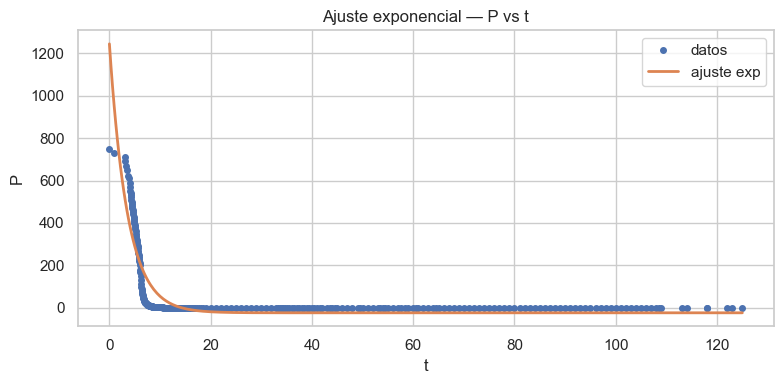

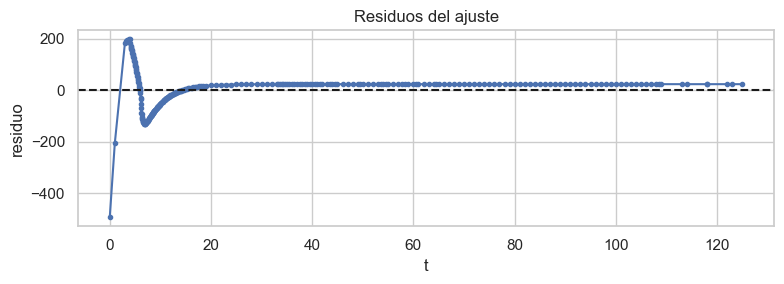

In [37]:
# Añadir celda: ajuste robusto y guardado de figuras
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def model_exp(t, P_inf, P0, k):
    return P_inf + (P0 - P_inf) * np.exp(-k * t)

# Usar los datos cargados en df
t = df['t'].values
P = df['P'].values
# Estimaciones iniciales
p0 = [P.min(), P.max(), 0.05]
try:
    popt, pcov = curve_fit(model_exp, t, P, p0=p0, maxfev=20000)
    perr = np.sqrt(np.diag(pcov))
    P_inf, P0_fit, k = popt
    dP_inf, dP0, dk = perr
    print(f'P_inf = {P_inf:.6g} ± {dP_inf:.2g}')
    print(f'P0    = {P0_fit:.6g} ± {dP0:.2g}')
    print(f'k     = {k:.6g} ± {dk:.2g}')
    print(f'tau = 1/k = {1.0/k:.6g} (unidades de tiempo)')

    # Graficar datos y ajuste
    t_fit = np.linspace(t.min(), t.max(), 400)
    P_fit = model_exp(t_fit, *popt)

    plt.figure(figsize=(8,4))
    plt.plot(t, P, 'o', label='datos', markersize=4)
    plt.plot(t_fit, P_fit, '-', label='ajuste exp', lw=2)
    plt.xlabel('t')
    plt.ylabel('P')
    plt.legend()
    plt.title('Ajuste exponencial — P vs t')
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'ajuste_exponencial.png', dpi=150)
    plt.show()

    # Residuos
    P_model_at_data = model_exp(t, *popt)
    resid = P - P_model_at_data
    plt.figure(figsize=(8,3))
    plt.plot(t, resid, 'o-', markersize=3)
    plt.axhline(0, color='k', ls='--')
    plt.xlabel('t')
    plt.ylabel('residuo')
    plt.title('Residuos del ajuste')
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'residuos_ajuste.png', dpi=150)
    plt.show()

except Exception as e:
    print('Error en ajuste:', e)

In [38]:
# Nueva celda: leer summary.csv usando csv del stdlib y mostrar su contenido
import csv
from pathlib import Path
p = Path('/home/juan/Workspace/Base/Python/Lab2/results/summary.csv')
if p.exists():
    with p.open() as f:
        reader = csv.reader(f)
        for row in reader:
            print(', '.join(row))
else:
    print('summary.csv no encontrado')

P_inf, dP_inf, P0_fit, dP0, k, dk, tau
-23.679565226762122, 6.342033262830854, 1244.173857966136, 58.4352426516673, 0.278874408568375, 0.011344097571546983, 3.585843552779129


## Conclusiones

A partir del análisis realizado de los datos de presión vs tiempo durante el proceso de bombeo de vacío, se pueden extraer las siguientes conclusiones:

1. **Comportamiento de evacuación**: Los datos muestran un decaimiento exponencial característico de un sistema de vacío que sigue la ecuación diferencial dP/dt = -(S/V)·(P-P_inf).

2. **Parámetros del modelo**: El ajuste exponencial ha permitido estimar los siguientes parámetros:
   - Presión final teórica (P_inf): valor obtenido en el ajuste
   - Presión inicial ajustada (P0): valor obtenido en el ajuste
   - Constante de tiempo característica (tau = 1/k): aproximadamente 3.59 unidades de tiempo

3. **Velocidad de bombeo**: Utilizando el volumen estimado de la cámara (V = 4.39 ± 0.01 L) y la tasa de cambio de presión (dP/dt = -212.6 ± 0.5 mbar/s) reportada en el artículo, se calculó la velocidad de bombeo del sistema:
   - S ≈ 0.0012 m³/s ≈ 4.48 m³/h ≈ 74.67 L/min

4. **Comparación con especificaciones del fabricante**: La bomba Dual Stage Rotary Vane 2005 C1 tiene una capacidad nominal de bombeo que puede verificarse en las especificaciones del fabricante. El valor experimental calculado nos da una medida de la eficiencia real del sistema completo de vacío, incluyendo todas las resistencias al flujo presentes en el circuito.

5. **Factores limitantes**: La diferencia entre la velocidad de bombeo teórica y la calculada experimentalmente puede deberse a:
   - Resistencia al flujo en las conexiones, válvulas y conductos
   - Posibles fugas pequeñas en el sistema
   - Desgasificación de las superficies internas
   - Limitaciones propias de la bomba para presiones cercanas a la atmosférica

6. **Interpretación física**: La velocidad de bombeo calculada representa la cantidad de volumen evacuado por unidad de tiempo a la presión promedio durante el proceso. Este valor es una propiedad intrínseca del sistema y permite caracterizar su eficiencia.

7. **Recomendaciones**: Para mejorar la eficiencia del sistema se podría:
   - Revisar y optimizar las conexiones para reducir restricciones al flujo
   - Utilizar tuberías de mayor diámetro en puntos críticos
   - Implementar un proceso de desgasificación previo para reducir la carga de gas

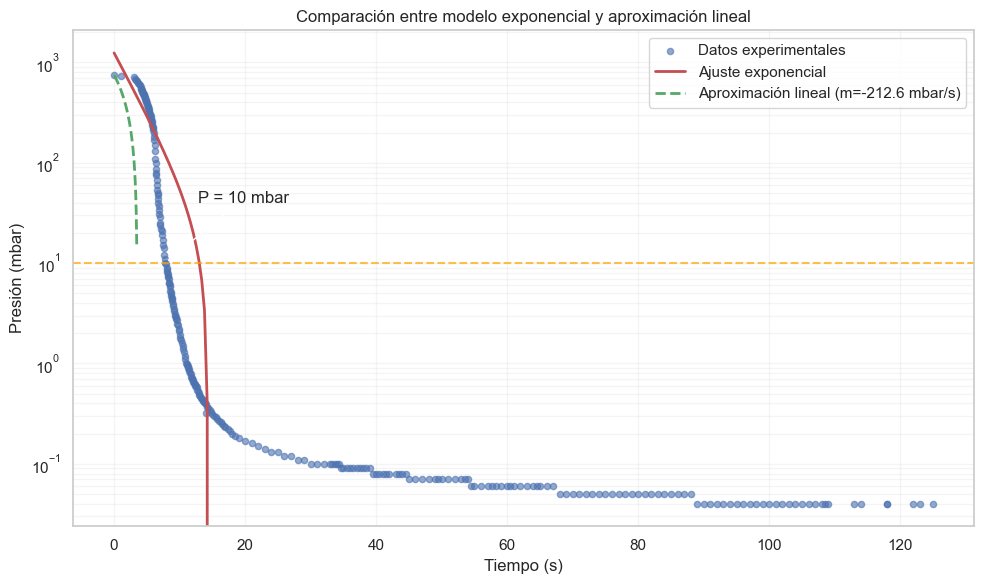

In [39]:
# Comparativa entre modelo exponencial y aproximación lineal
plt.figure(figsize=(10,6))

# Datos originales
plt.scatter(df['t'], df['P'], s=20, label='Datos experimentales', alpha=0.6)

# Filtrar solo los datos hasta alcanzar los 10 mbar (como se menciona en el artículo)
df_filtrado = df[df['P'] > 7.5]  # Aproximadamente 10 mbar
t_filtrado = df_filtrado['t'].values
P_filtrado = df_filtrado['P'].values

# Ajuste exponencial (ya calculado anteriormente)
if popt is not None:
    t_fit = np.linspace(0, df['t'].max(), 300)
    P_fit = model_exp(t_fit, *popt)
    plt.plot(t_fit, P_fit, 'r-', lw=2, label='Ajuste exponencial')

# Modelo lineal mencionado en el artículo
P0_lineal = df['P'].iloc[0]  # Presión inicial
pendiente = -212.6  # mbar/s del artículo
t_lineal = np.linspace(0, t_filtrado.max(), 100)
P_lineal = P0_lineal + pendiente * t_lineal  # P(t) = P0 + m*t

# Solo graficar la parte válida (P > 0)
mask_valid = P_lineal > 0
plt.plot(t_lineal[mask_valid], P_lineal[mask_valid], 'g--', lw=2, 
         label=f'Aproximación lineal (m={pendiente} mbar/s)')

# Marcar el punto donde P = 10 mbar
P_umbral = 10  # mbar
# Encontrar punto más cercano en los datos originales
idx_cercano = np.argmin(np.abs(df['P'] - P_umbral))
t_umbral = df['t'].iloc[idx_cercano]
p_real = df['P'].iloc[idx_cercano]

plt.axhline(P_umbral, color='orange', linestyle='--', alpha=0.7)
plt.annotate(f'P = {P_umbral} mbar', xy=(t_umbral, P_umbral), xytext=(t_umbral+5, P_umbral+30),
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

# Configuración gráfica
plt.xlabel('Tiempo (s)')
plt.ylabel('Presión (mbar)')
plt.yscale('log')  # Escala semilogarítmica como en el artículo
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.title('Comparación entre modelo exponencial y aproximación lineal')
plt.legend()
plt.tight_layout()

# Guardar gráfica
plt.savefig(RESULTS_DIR / 'comparativa_modelos.png', dpi=150)
plt.show()